In [1]:
# Imports
import numpy as np
import pandas as pd 
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("./archive/ai_human_content_detection_dataset.csv")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 755}
CV Mean Train Accuracy: 0.919
CV Mean Validation Accuracy: 0.497
Training Accuracy: 0.925
Validation Accuracy: 0.497
Test Accuracy: 0.544
ROC-AUC: 0.541


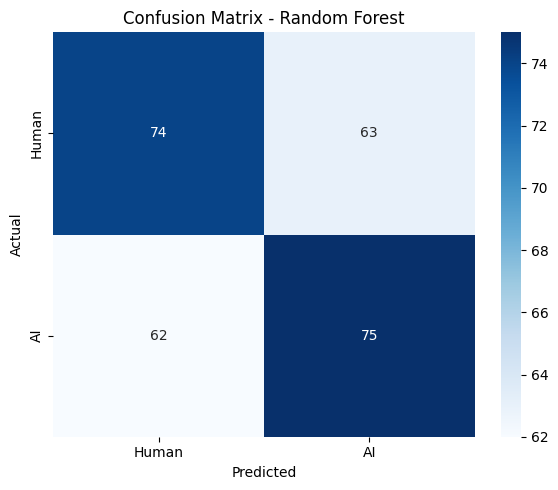

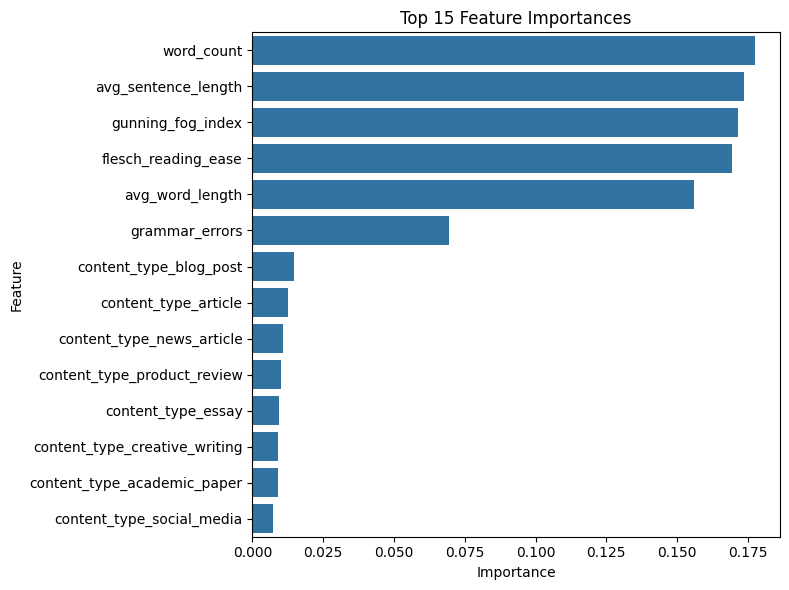

In [ ]:
# Dataprep Section

# Drop text column and label
# Features
X = df.drop(columns=['label', 'text_content'])
# Target
y = df['label']

# Select only base useful numeric and categorical columns
numeric = [
    'word_count', 'avg_word_length', 'avg_sentence_length',
    'flesch_reading_ease', 'gunning_fog_index',
    'grammar_errors', 'punctuation_count'
]

categorical = ['content_type']

# Ensure only existing columns are selected 
numeric = [col for col in numeric if col in X.columns]
categorical = [col for col in categorical if col in X.columns]

# Imputer, Scaler, and One-Hot-Encoding 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer for bringing the preprocessing together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)
    ]
)

# Model Definition
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# RFC parameter distributions for use in the RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': randint(200, 1000),
    'classifier__max_depth': [None] + list(range(5, 40, 5)),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', 0.8, 0.5],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

# Complete pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Randomized Search with 5-fold CV and 30 random combinations
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Model Fitting
search.fit(X_train, y_train)

# Model Reporting

# Model Performance printing
cv_results = pd.DataFrame(search.cv_results_)
best_idx = search.best_index_
best_train_acc = cv_results.loc[best_idx, 'mean_train_score']
best_val_acc = cv_results.loc[best_idx, 'mean_test_score']

# Best hyperparameters from the RSCV
print("\nBest Parameters:")
print(search.best_params_)
print(f"CV Mean Train Accuracy: {best_train_acc:.3f}")
print(f"CV Mean Validation Accuracy: {best_val_acc:.3f}")

# Final Evaluation
best_model = search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
roc = roc_auc_score(y_test, y_prob_test)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {best_val_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"ROC-AUC: {roc:.3f}")

# Confusion Matrix Plot
conf_mat = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# Most Impactful Features Plot
clf = best_model.named_steps['classifier']
feature_names_num = numeric
feature_names_cat = list(
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical)
)
all_features = feature_names_num + feature_names_cat

importances = pd.Series(clf.feature_importances_, index=all_features)
importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show() 
